# Imports

In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import explained_variance_score
from datetime import datetime

In [2]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, Activation, Dropout
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.python.keras import regularizers

# Load Data

In [3]:
#####################################################################################################
################################ Select numbers of year of data #####################################
#####################################################################################################
year = 5 # years of data to compare 10 or 5

In [4]:
cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'] 

PSIdf = pd.read_csv(r'stock_indices/PSI_{}y.csv'.format(year), usecols = cols).drop(columns = ['Adj Close'])
SOXXdf = pd.read_csv(r'stock_indices/SOXX_{}y.csv'.format(year), usecols = cols).drop(columns = ['Adj Close'])
USDdf = pd.read_csv(r'stock_indices/USD_{}y.csv'.format(year),  usecols = cols).drop(columns = ['Adj Close'])
SMHdf = pd.read_csv(r'stock_indices/SMH_{}y.csv'.format(year),  usecols = cols).drop(columns = ['Adj Close'])
SOXLdf = pd.read_csv(r'stock_indices/SOXL_{}y.csv'.format(year),  usecols = cols).drop(columns = ['Adj Close'])
TSMdf = pd.read_csv(r'stock_indices/TSM_{}y.csv'.format(year),  usecols = cols).drop(columns = ['Adj Close'])

In [5]:
restCol = lambda name: { h:   name + ' ' + h   for h in ['Volume', 'Close', 'Open', 'High', 'Low']}

PSIdf.rename(columns = restCol('PSI'), inplace = True)
SOXXdf.rename(columns = restCol('SOXX'), inplace = True)
USDdf.rename(columns = restCol('USD'), inplace = True)
SMHdf.rename(columns = restCol('SMH'), inplace = True)
SOXLdf.rename(columns = restCol('SOXL'), inplace = True)
TSMdf.rename(columns = restCol('TSM'), inplace = True)

# if mergeAll:
#     df = pd.merge(PSIdf, SOXXdf, how = 'inner', on = 'Date', sort=True).set_index(['Date']) 
#     df = pd.merge(df, USDdf, how = 'inner', on = 'Date', sort=True).set_index(['Date']) 
#     df = pd.merge(df, SMHdf, how = 'inner', on = 'Date', sort=True).set_index(['Date']) 
#     df = pd.merge(df, SOXLdf, how = 'inner', on = 'Date', sort=True).set_index(['Date'])  
#     df = pd.merge(df, TSMdf, how = 'inner', on = 'Date', sort=True).set_index(['Date'])  

In [6]:
######################################################################################################
################################### Select the indice for input ######################################
######################################################################################################
indiceToCmpr = SMHdf #PSIdf # SOXXdf, USDdf, SMHdf, SOXLdf
includeTargInInput = False

In [7]:
df = pd.merge(indiceToCmpr, TSMdf, how = 'inner', on = 'Date', sort=True).set_index(['Date']) 
df['TSM Avg'] = (df['TSM High'] + df['TSM Low'])/2

In [8]:
target_col = ['TSM Avg']
input_col = [col for col in df.columns if 'TSM' not in col] if not includeTargInInput else df.columns
print("The input col is: ", input_col)

The input col is:  ['SMH Open', 'SMH High', 'SMH Low', 'SMH Close', 'SMH Volume']


In [9]:
#####################################################################################################
################################### shift days ######################################################
#####################################################################################################
shift_steps = 5 #shift day

In [10]:
#With shift
if shift_steps:
    df_targets = df[target_col].shift(-shift_steps)
    y_data = df_targets.values[0:-shift_steps]
    x_data = df[input_col].values[0:-shift_steps]
else:
    #No shift
    df_targets = df[target_col]
    y_data = df_targets.values
    x_data = df[input_col].values

### NumPy Arrays

In [11]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (1254, 5)


In [12]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (1254, 1)


In [13]:
num_data = len(x_data)
num_data

1254

In [14]:
train_split = 0.8

In [15]:
num_train = int(train_split * num_data)
num_train

1003

In [16]:
num_test = num_data - num_train
num_test

251

In [17]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

1254

In [18]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

1254

In [19]:
num_x_signals = x_data.shape[1]
num_x_signals

5

In [20]:
num_y_signals = y_data.shape[1] if len(target_col) > 1 else 1

### Scaled Data

In [21]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 43.529999
Max: 21540200.0


In [22]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train) # calculate std and mean, store it into xscaler, apply that to transform
x_test_scaled = x_scaler.transform(x_test)

In [23]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [24]:
if num_y_signals == 1:
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)     #reshape to fit numpy array of shape [n_samples, n_features]

In [25]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

### Data Generator

In [26]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(1003, 5)
(1003, 1)


In [27]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [28]:
batch_size = 256

In [29]:
sequence_length = 100

In [30]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [31]:
x_batch, y_batch = next(generator)

In [32]:
print(x_batch.shape)
print(y_batch.shape)

(256, 100, 5)
(256, 100, 1)


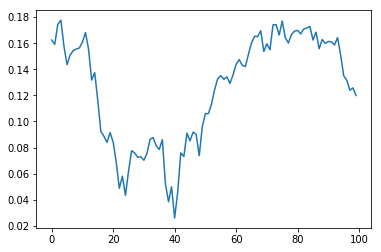

In [33]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

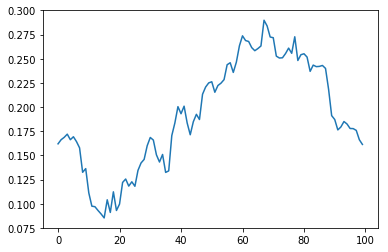

In [34]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

### Validation Set

In [35]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

# Create the Recurrent Neural Network

In [36]:
model = Sequential()

In [37]:
model.add(GRU(units=128,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [38]:
from tensorflow.python.keras.initializers import RandomUniform
from tensorflow.python.keras import regularizers

model.add(Dense(num_y_signals, activation='relu'))  

# Maybe use lower init-ranges.
# init = RandomUniform(minval=-0.05, maxval=0.05)
# model.add(Dense(num_y_signals,activation='relu',kernel_initializer=init, kernel_regularizer=regularizers.l2(0.01)))
# model.add(Dense(num_y_signals, Dropout(0.5))) # dropout layer
# model.add(Dense(num_y_signals,activation='relu',kernel_initializer=init))

### Loss Function

In [39]:
warmup_steps = 50

In [40]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

### Compile Model

In [41]:
optimizer = RMSprop(lr=1e-3)

In [42]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 128)         51456     
_________________________________________________________________
dense (Dense)                (None, None, 1)           129       
Total params: 51,585
Trainable params: 51,585
Non-trainable params: 0
_________________________________________________________________


### Callback Functions

In [44]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [45]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [46]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_images=True)

In [47]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [48]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

## Estimate training time

In [49]:
import time
t0 = time.time()

# Train the Neural Network

In [50]:
# %%time
history = model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0048
Epoch 00001: val_loss improved from inf to 0.02933, saving model to 23_checkpoint.keras
100/100 [==============================] - 60s 595ms/step - loss: 0.0048 - val_loss: 0.0293
Epoch 2/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0031
Epoch 00002: val_loss improved from 0.02933 to 0.00759, saving model to 23_checkpoint.keras
100/100 [==============================] - 58s 584ms/step - loss: 0.0031 - val_loss: 0.0076
Epoch 3/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0028
Epoch 00003: val_loss did not improve from 0.00759

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 57s 571ms/step - loss: 0.0028 - val_loss: 0.0092
Epoch 4/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0024
Epoch 00004: val_loss did not improve from 0.00759

Epoch 00004: ReduceLROnPlateau reducing learning ra

In [51]:
print("Training time: ", round(time.time()-t0, 3), "s")

Training time:  391.323 s


### Load Checkpoint

In [52]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

# Performance on Test-Set

In [53]:
loss = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 63ms/step


In [54]:
print("loss (test-set):{0}".format(loss))

loss (test-set):0.0075874002650380135


In [55]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

# Generate Predictions

In [56]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    print("y_pred length: ", len(y_pred))
    print("y_true length: ",len(y_true))
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    print("y_pred_rescaled length: ", len(y_pred_rescaled))
    print("Explained variance score (EVS): ", explained_variance_score(y_true, y_pred_rescaled))
    
    # For each output-signal.
    for signal in range(len(target_col)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        #plt.ylabel(target_names[signal])
        plt.ylabel('TSM Average')
        plt.legend()
        plt.show()

y_pred length:  1
y_true length:  1003
y_pred_rescaled length:  1003
Explained variance score (EVS):  0.9611468862782943


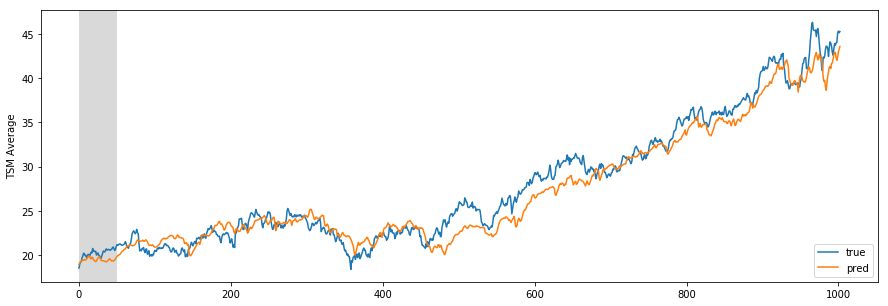

In [57]:
plot_comparison(start_idx=0, length=1200, train=True)

### Example from Test-Set

y_pred length:  1
y_true length:  251
y_pred_rescaled length:  251
Explained variance score (EVS):  0.22705075541676945


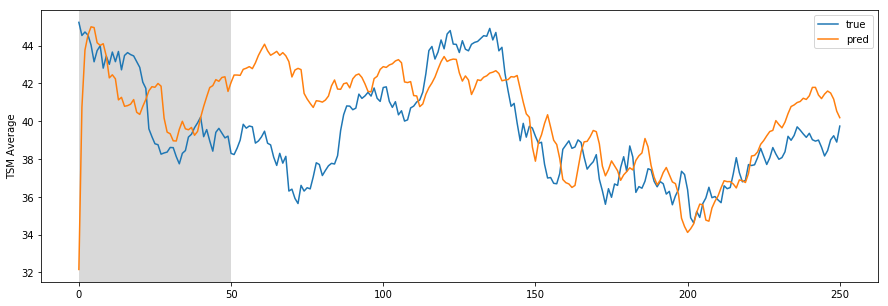

In [58]:
plot_comparison(start_idx=0, length=260, train=False)

### Summarize history of loss

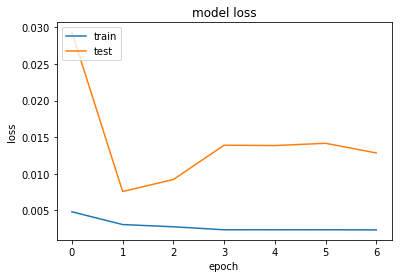

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()